In [80]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive 
from oauth2client.client import GoogleCredentials

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [81]:
pip install transformers

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import classification_report

In [83]:
df = pd.read_csv('gdrive/MyDrive/text_pre_processing.csv', sep=',')
df.head(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Unnamed: 0.1,title,text,subject,date,label,caps_in_title,text_tokens,text_urls,clean_text,title_urls,twitter_handles,clean_title,clean_text_tokens,clean_title_tokens
0,0,0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake,11,"['Donald', 'Trump', 'just', 'couldn', 't', 'wi...",['pic.twitter.com/4FPAe2KypA'],donald trump just couldn t wish all americans ...,[],"['@realDonaldTrump', '@TalbertSwan', '@calvins...",donald trump sends out embarrassing new year’s...,"['donald', 'trump', 'just', 'couldn', 'wish', ...","['donald', 'trump', 'sends', 'out', 'embarrass..."
1,1,1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake,8,"['House', 'Intelligence', 'Committee', 'Chairm...",[],house intelligence committee chairman devin nu...,[],[],drunk bragging trump staffer started russian c...,"['house', 'intelligence', 'committee', 'chairm...","['drunk', 'bragging', 'trump', 'staffer', 'sta..."
2,2,2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake,15,"['On', 'Friday', 'it', 'was', 'revealed', 'tha...","['pic.twitter.com/XtZW5PdU2b', 'pic.twitter.co...","on friday, it was revealed that former milwauk...",[],"['@SheriffClarke', '@SheriffClarke', '@KeithLe...",sheriff david clarke becomes an internet joke ...,"['on', 'it', 'was', 'revealed', 'that', 'forme...","['sheriff', 'david', 'clarke', 'becomes', 'an'..."
3,3,3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,fake,19,"['On', 'Christmas', 'day', 'Donald', 'Trump', ...","['https://t.co/Fg7VacxRtJ', 'pic.twitter.com/5...","on christmas day, donald trump announced that ...",[],"['@pbump', '@_cingraham', '@_cingraham', '@_ci...",trump is so obsessed he even has obama’s name ...,"['on', 'christmas', 'day', 'donald', 'trump', ...","['trump', 'is', 'so', 'obsessed', 'he', 'even'..."
4,4,4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,fake,11,"['Pope', 'Francis', 'used', 'his', 'annual', '...",[],pope francis used his annual christmas day mes...,[],[],pope francis just called out donald trump duri...,"['pope', 'francis', 'used', 'his', 'annual', '...","['pope', 'francis', 'just', 'called', 'out', '..."


In [84]:
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.drop(['Unnamed: 0.1'], axis = 1)
df = df.drop(['text_tokens'], axis = 1)
df = df.drop(['text_urls'], axis = 1)
df = df.drop(['title_urls'], axis = 1)
df = df.drop(['twitter_handles'], axis = 1)
df = df.drop(['clean_text_tokens'], axis = 1)
df = df.drop(['clean_title_tokens'], axis = 1)
df.head(5)

,title,text,subject,date,label,caps_in_title,clean_text,clean_title
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake,11,donald trump just couldn t wish all americans ...,donald trump sends out embarrassing new year’s...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake,8,house intelligence committee chairman devin nu...,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake,15,"on friday, it was revealed that former milwauk...",sheriff david clarke becomes an internet joke ...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,fake,19,"on christmas day, donald trump announced that ...",trump is so obsessed he even has obama’s name ...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,fake,11,pope francis used his annual christmas day mes...,pope francis just called out donald trump duri...


In [85]:
#add the target column
df['Target'] = df['label'].apply(lambda x: 'True' if x == True else 'False')

In [86]:
#The Target column is made of strings, and it is not computer-friendly. So we adjust it
df['label']=pd.get_dummies(df.Target)

Text Classification using Bert

In [87]:
#1.Train-Validation split
train_text, temp_text, train_labels, temp_labels = train_test_split(df['clean_title'],df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.25, 
                                                                    stratify=df['Target'])

In [88]:
#2.Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.15, 
                                                                stratify=temp_labels)

So, we will fine-tune the model using the train set and the validation set, and make predictions for the test set.

In [89]:
#3.Defining the model and the tokenizer of BERT.

#import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

#Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [90]:
#plot style
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (10, 10
                                 ) 
plt.rcParams['axes.grid']=False
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale range', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

Text(0, 0.5, 'Number of texts')

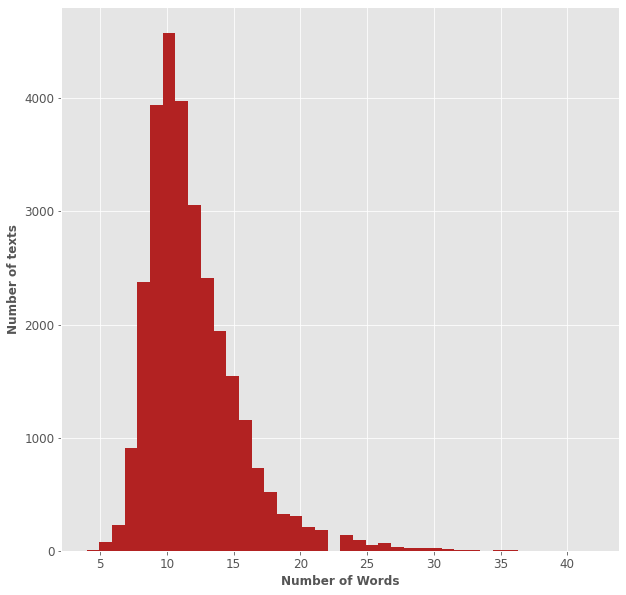

In [91]:
#4.Plotting the histogram
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

Since the text in the dataset are of varying length, therefore we will use padding to make all the messages have the same length. We can use the maximum sequence length to pad the messages. However, using the previous histogram we find the righ padding lenght. We will use the max lenght equal to the mean of words in a title.

In [92]:
import statistics
seq_len = [len(i.split()) for i in train_text]
MAX_LENGHT = int(statistics.mean(seq_len))
print(MAX_LENGHT)

11


In [93]:
#MAX_LENGHT = 399

#tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [94]:
#5.Converting lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist()) 

Now we will create dataloaders for both train and validation set. These dataloaders will pass batches of train data and validation data as input to the model during the training phase.

In [95]:
#6.Data Loader structure definition:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


Define Model Architecture 

In [96]:
#7.Freezing the parameters and defining the trainable BERT structure:
for param in bert.parameters():
    param.requires_grad = False

We freeze all the layers of the model before fine-tuning it. This will prevent updating of model weights during fine-tuning

In [97]:
#define our model architecture.
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [98]:
model = BERT_Arch(bert)

We will use AdamW as our optimizer.

In [99]:
#8.Defining the hyperparameters (optimizer, weights of the classes and the epochs)
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

In [100]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [3.29145843 0.58955892]


In [101]:
weights= torch.tensor(class_weights,dtype=torch.float)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

Fine-Tune BERT

In [102]:
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r for r in batch]
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        
    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [103]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
       
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [104]:
# Train and predict
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    906.
  Batch   100  of    906.
  Batch   150  of    906.
  Batch   200  of    906.
  Batch   250  of    906.
  Batch   300  of    906.
  Batch   350  of    906.
  Batch   400  of    906.
  Batch   450  of    906.
  Batch   500  of    906.
  Batch   550  of    906.
  Batch   600  of    906.
  Batch   650  of    906.
  Batch   700  of    906.
  Batch   750  of    906.
  Batch   800  of    906.
  Batch   850  of    906.
  Batch   900  of    906.

Evaluating...
  Batch    50  of    257.
  Batch   100  of    257.
  Batch   150  of    257.
  Batch   200  of    257.
  Batch   250  of    257.

Training Loss: 0.654
Validation Loss: 0.613

 Epoch 2 / 10
  Batch    50  of    906.
  Batch   100  of    906.
  Batch   150  of    906.
  Batch   200  of    906.
  Batch   250  of    906.
  Batch   300  of    906.
  Batch   350  of    906.
  Batch   400  of    906.
  Batch   450  of    906.
  Batch   500  of    906.
  Batch   550  of    906.
  Batch   600  of    906.


In [105]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

Evaluation

We will evaluate the model using the classificationr eport, confusion amtrix and the Precision Recall Curve.

In [106]:
with torch.no_grad():
    preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()

In [107]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.43      0.84      0.57       220
           1       0.97      0.80      0.88      1229

    accuracy                           0.81      1449
   macro avg       0.70      0.82      0.73      1449
weighted avg       0.89      0.81      0.83      1449



In [108]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [109]:
conf_mat = confusion_matrix(y_true=test_y, y_pred=preds,labels =[0, 1])
pd.DataFrame(conf_mat, columns = [0,1],index = [0, 1])

,0,1
0,185,35
1,241,988


In [111]:
from sklearn.metrics import precision_recall_curve

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [113]:
device

device(type='cpu')

In [114]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

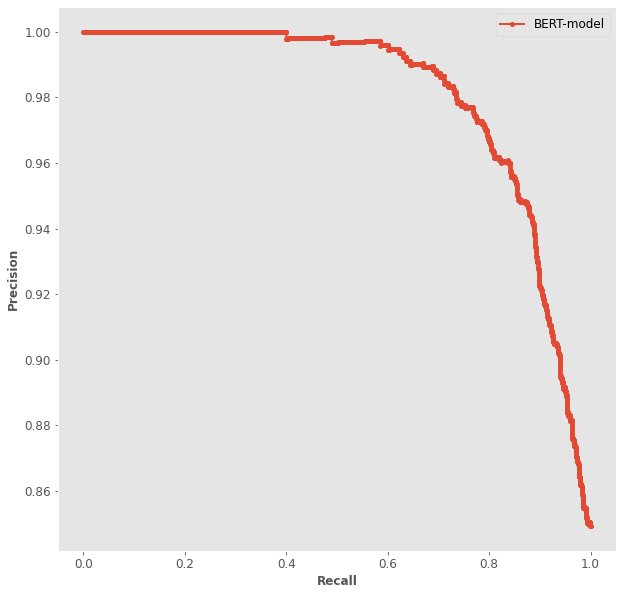

In [115]:
# model's performance
precision_, recall_, proba = precision_recall_curve(test_y, preds[:, -1])
preds = np.argmax(preds, axis = 1)
#plot precision-recall curve
plt.plot(recall_, precision_, marker='.', label='BERT-model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()